In [61]:
import numpy as np 
import pickle
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def clean_roi(roi_vals, roi_labels):
    roi_vals = roi_vals.reshape((len(roi_vals), ))
    final_roi_labels = []
    for val_index in roi_vals:
        if val_index == 0:
            final_roi_labels.append("other")
        else:
            final_roi_labels.append(roi_labels[val_index-1][0][0])
    return final_roi_labels

def clean_atlas(atlas_vals, atlas_labels):
    at_vals = atlas_vals.reshape((len(atlas_vals), ))
    at_labels = []
    for val_index in at_vals:
        at_labels.append(atlas_labels[val_index-1][0][0])
    return at_labels

In [3]:
# get residuals
avg_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-avg.p"
avg_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-avg.p"

max_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-max.p"
max_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-max.p"

min_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-min.p"
min_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-min.p"

last_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-last.p"
last_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-last.p"

# open files
avg_residual_layer1 = pickle.load( open( avg_residual_file_layer1, "rb" ) )
avg_residual_layer2 = pickle.load( open( avg_residual_file_layer2, "rb" ) )

max_residual_layer1 = pickle.load( open( max_residual_file_layer1, "rb" ) )
max_residual_layer2 = pickle.load( open( max_residual_file_layer2, "rb" ) )

min_residual_layer1 = pickle.load( open( min_residual_file_layer1, "rb" ) )
min_residual_layer2 = pickle.load( open( min_residual_file_layer2, "rb" ) )

last_residual_layer1 = pickle.load( open( last_residual_file_layer1, "rb" ) )
last_residual_layer2 = pickle.load( open( last_residual_file_layer2, "rb" ) )

In [4]:
# get atlas and roi
atlas_vals = pickle.load( open( "atlas_vals.p", "rb" ) )
atlas_labels = pickle.load( open( "atlas_labels.p", "rb" ) )
roi_vals = pickle.load( open( "roi_vals.p", "rb" ) )
roi_labels = pickle.load( open( "roi_labels.p", "rb" ) )

final_roi_labels = clean_roi(roi_vals, roi_labels)
at_labels = clean_atlas(atlas_vals, atlas_labels)

In [15]:
# get activations
activations = pickle.load( open( "activations.p", "rb" ) )
modified_activations = pickle.load( open( "modified_activations.p", "rb" ) )

In [19]:
print(len(activations[0]))

151247
79


In [14]:
len(roi_labels)

8

In [13]:
len(roi_vals)

151247

In [5]:
# make dataframe
df_dict_single = {'voxel_index': list(range(len(avg_residual_layer1))), 
        'residuals': avg_residual_layer1, 
        'atlas_labels': at_labels, 
        'roi_labels': final_roi_labels}

df_single = pd.DataFrame(df_dict_single)

In [6]:
df_dict = {'voxel_index': list(range(len(at_labels))) * 8, 
            'residuals': avg_residual_layer1 + avg_residual_layer2 + max_residual_layer1 + max_residual_layer2 + min_residual_layer1 + min_residual_layer2 + last_residual_layer1 + last_residual_layer2, 
            'atlas_labels': at_labels * 8, 
            'roi_labels': final_roi_labels * 8,
            'agg_type': ['avg']*len(at_labels)*2 + ['max']*len(at_labels)*2 + ['min']*len(at_labels)*2 + ['last']*len(at_labels)*2,
            'layer': (['layer1']*len(at_labels) + ['layer2']*len(at_labels))*4 }

df = pd.DataFrame(df_dict)

In [7]:
df.head()

,agg_type,atlas_labels,layer,residuals,roi_labels,voxel_index
0,avg,Cerebelum_8_L,layer1,5.530148e-12,other,0
1,avg,Cerebelum_7b_L,layer1,5.547563e-12,other,1
2,avg,Cerebelum_8_R,layer1,5.181878e-12,other,2
3,avg,Cerebelum_8_L,layer1,5.271514e-12,other,3
4,avg,Cerebelum_8_L,layer1,5.446057e-12,other,4


In [37]:
df_avg = df[df.agg_type == 'avg'][df.layer == 'layer1']

/Users/christinejou/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [38]:
df_avg.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            151237, 151238, 151239, 151240, 151241, 151242, 151243, 151244,
            151245, 151246],
           dtype='int64', length=151247)

### get activations locations

In [59]:
def get_location(df, atype, layer_num, names, activations):
    df_agg = df[df.agg_type == atype][df.layer == layer_num]
    indices = []
    for name in names:
        index = df_agg.index[df_agg['atlas_labels'] == name].tolist()
        indices += index
    all_activations = [activations[x] for x in indices]
    return np.nansum(all_activations), np.nansum(all_activations) // len(all_activations)
    print("SUM: ", np.nansum(all_activations))
    print("AVG: ", np.nansum(all_activations) // len(all_activations))

### cerebelum activations

In [62]:
cerebelum = ['Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_R', 'Cerebelum_9_L', 'Cerebelum_7b_L', 'Cerebelum_7b_R']
c_vals_sum = []
c_vals_avg = []
for i in tqdm(range(240)):
    c_sum, c_avg = get_location(df, "avg", "layer1", cerebelum, activations[i])
    c_vals_sum.append(c_sum)
    c_vals_avg.append(c_avg)

  0%|          | 0/240 [00:00<?, ?it/s]/Users/christinejou/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
100%|██████████| 240/240 [02:01<00:00,  2.09it/s]


In [67]:
np.sum(c_vals_sum) // len(c_vals_sum)

-77.0

In [68]:
print(np.sum(np.abs(c_vals_sum)) // len(c_vals_sum))
print(np.sum(np.abs(c_vals_avg)) // len(c_vals_avg))

3255.0
1.0


In [39]:
cerebelum8l = df_avg.index[df_avg['atlas_labels'] == 'Cerebelum_8_L'].tolist()
cerebelum8r = df_avg.index[df_avg['atlas_labels'] == 'Cerebelum_8_R'].tolist()
cerebelum9r = df_avg.index[df_avg['atlas_labels'] == 'Cerebelum_9_R'].tolist()
cerebelum9l = df_avg.index[df_avg['atlas_labels'] == 'Cerebelum_9_L'].tolist()
cerebelum7bl = df_avg.index[df_avg['atlas_labels'] == 'Cerebelum_7b_L'].tolist()
cerebelum7br = df_avg.index[df_avg['atlas_labels'] == 'Cerebelum_7b_R'].tolist()

In [40]:
all_cerebelum = cerebelum8l + cerebelum8r + cerebelum9r + cerebelum9l + cerebelum7bl + cerebelum7br
print(len(all_cerebelum))

3021


In [42]:
all_cerebelum_activations = [activations[0][x] for x in all_cerebelum]

In [52]:
np.nansum(all_cerebelum_activations)

5165.6349260791103

In [48]:
np.nansum(all_cerebelum_activations) // len(all_cerebelum_activations)

1.0

### caudate activations

In [70]:
caudate = ['Caudate_R', 'Caudate_L']
caudate_vals_sum = []
caudate_vals_avg = []
for i in tqdm(range(240)):
    cad_sum, cad_avg = get_location(df, "avg", "layer1", caudate, activations[i])
    caudate_vals_sum.append(cad_sum)
    caudate_vals_avg.append(cad_avg)


  0%|          | 0/240 [00:00<?, ?it/s]/Users/christinejou/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  

100%|██████████| 240/240 [01:32<00:00,  2.68it/s]


In [71]:
print(np.sum(np.abs(caudate_vals_sum)) // len(caudate_vals_sum))
print(np.sum(np.abs(caudate_vals_avg)) // len(caudate_vals_avg))

3436.0
1.0


In [50]:
caudate_r = df_avg.index[df_avg['atlas_labels'] == 'Caudate_R'].tolist()
caudate_l = df_avg.index[df_avg['atlas_labels'] == 'Caudate_L'].tolist()
all_caudate = caudate_r + caudate_l
all_caudate_activations = [activations[0][x] for x in all_caudate]

In [53]:
np.nansum(all_caudate_activations)

7167.65239075711

In [51]:
np.nansum(all_caudate_activations) // len(all_caudate_activations)

3.0

In [10]:
df.atlas_labels.unique()

array(['Cerebelum_8_L', 'Cerebelum_7b_L', 'Cerebelum_8_R', 'Cerebelum_9_R',
       'Cerebelum_9_L', 'Cerebelum_7b_R', 'Cerebelum_Crus2_R',
       'Cerebelum_Crus2_L', 'Cerebelum_10_R', 'Cerebelum_10_L', 'Vermis_8',
       'Vermis_9', 'Cerebelum_Crus1_R', 'Cerebelum_Crus1_L', 'Vermis_10',
       'Cerebelum_6_R', 'Temporal_Pole_Mid_R', 'Cerebelum_6_L', 'Vermis_7',
       'Cerebelum_4_5_L', 'Temporal_Inf_R', 'Cerebelum_4_5_R',
       'Temporal_Pole_Mid_L', 'Temporal_Mid_R', 'Temporal_Mid_L',
       'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Inf_L',
       'Fusiform_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Fusiform_L',
       'ParaHippocampal_R', 'Frontal_Inf_Orb_R', 'Frontal_Sup_Orb_L',
       'Rectus_R', 'Rectus_L', 'Frontal_Inf_Orb_L', 'Frontal_Sup_Orb_R',
       'Vermis_6', 'Vermis_4_5', 'Vermis_1_2', 'ParaHippocampal_L',
       'Amygdala_R', 'Vermis_3', 'Hippocampus_L', 'Olfactory_R',
       'Insula_R', 'Insula_L', 'Frontal_Mid_Orb_R', 'Frontal_Mid_Orb_L',
       'Lingual_L

In [11]:
len(avg_residual_layer1)

151247

## language ROI

### avg

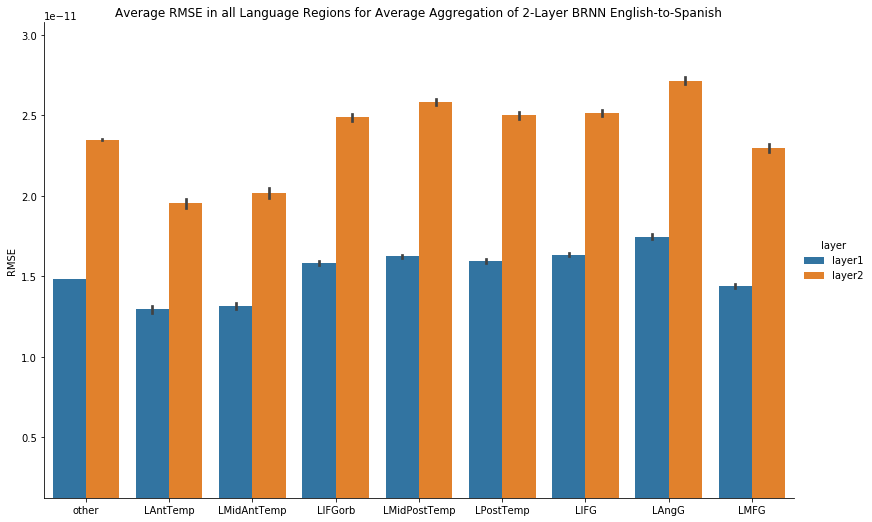

In [60]:
df_avg = df[df.agg_type == 'avg']
g = sns.catplot(x="roi_labels", y="residuals", data=df_avg, hue="layer", kind="bar", height=7.5, aspect=1.5)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Language Regions for Average Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### max

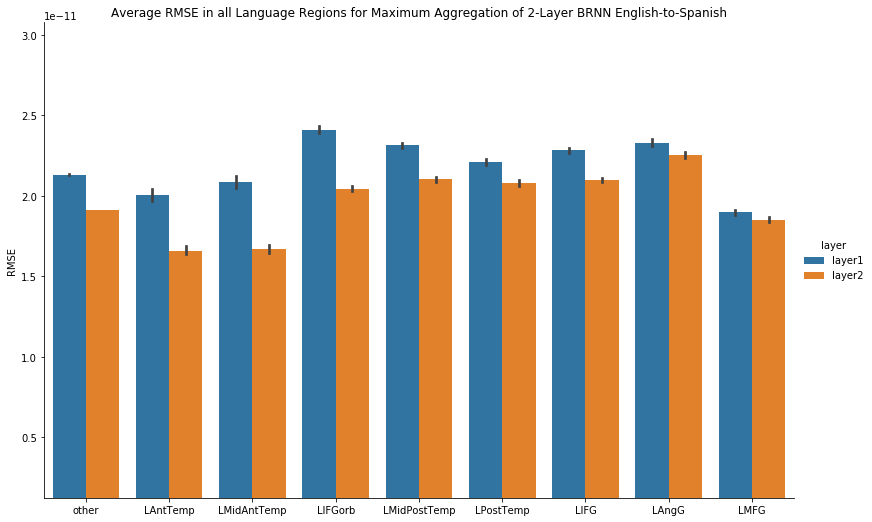

In [61]:
df_max = df[df.agg_type == 'max']
g = sns.catplot(x="roi_labels", y="residuals", data=df_max, hue="layer", kind="bar", height=7.5, aspect=1.5)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Language Regions for Maximum Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### min

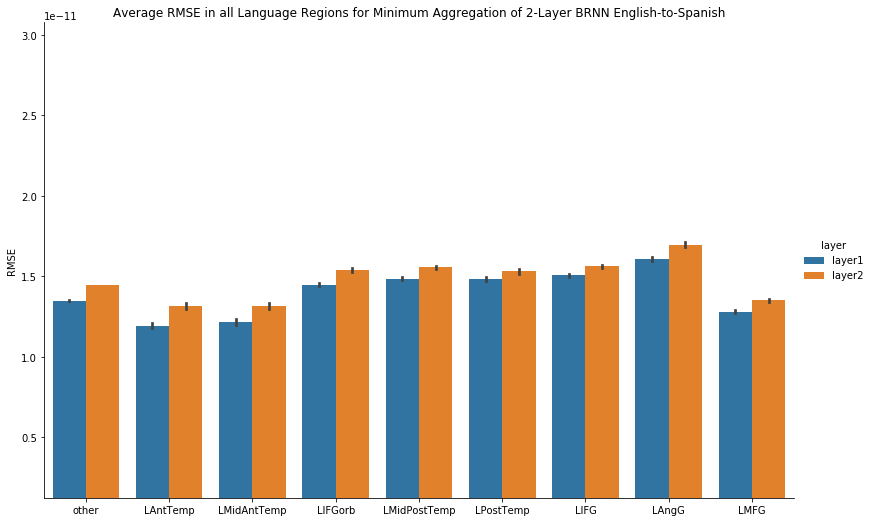

In [62]:
df_min = df[df.agg_type == 'min']
g = sns.catplot(x="roi_labels", y="residuals", data=df_min, hue="layer", kind="bar", height=7.5, aspect=1.5)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Language Regions for Minimum Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### last

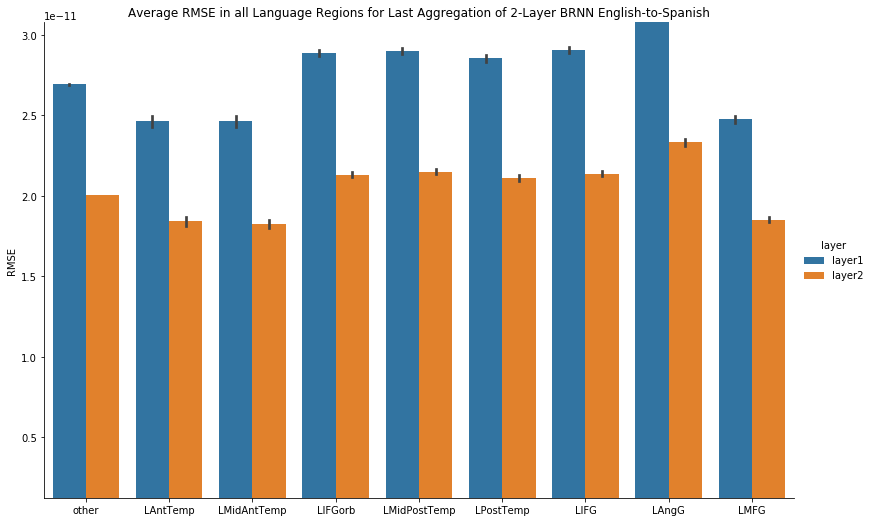

In [63]:
df_last = df[df.agg_type == 'last']
g = sns.catplot(x="roi_labels", y="residuals", data=df_last, hue="layer", kind="bar", height=7.5, aspect=1.5)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Language Regions for Last Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### average of layers

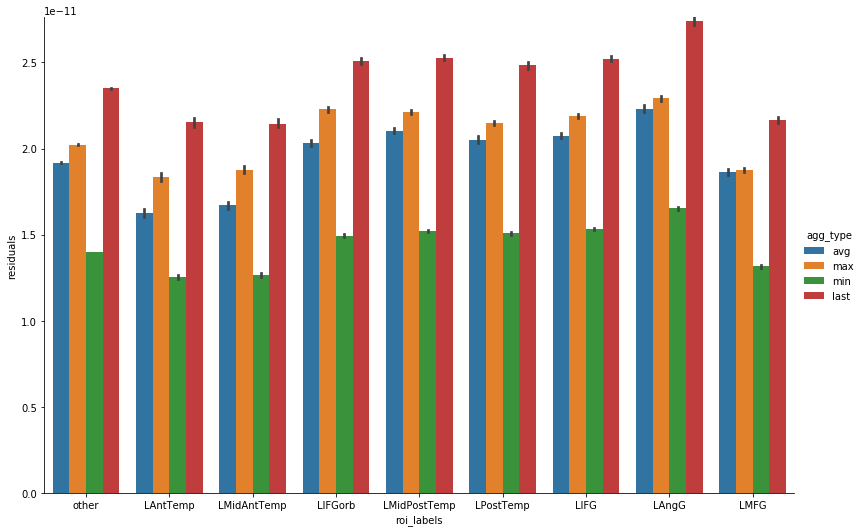

In [25]:
%matplotlib inline
g = sns.catplot(x="roi_labels", y="residuals", data=df, hue="agg_type", kind="bar", height=7.5, aspect=1.5)
# g.set_xticklabels(rotation=90)
plt.show()

## AAL ROI

### avg

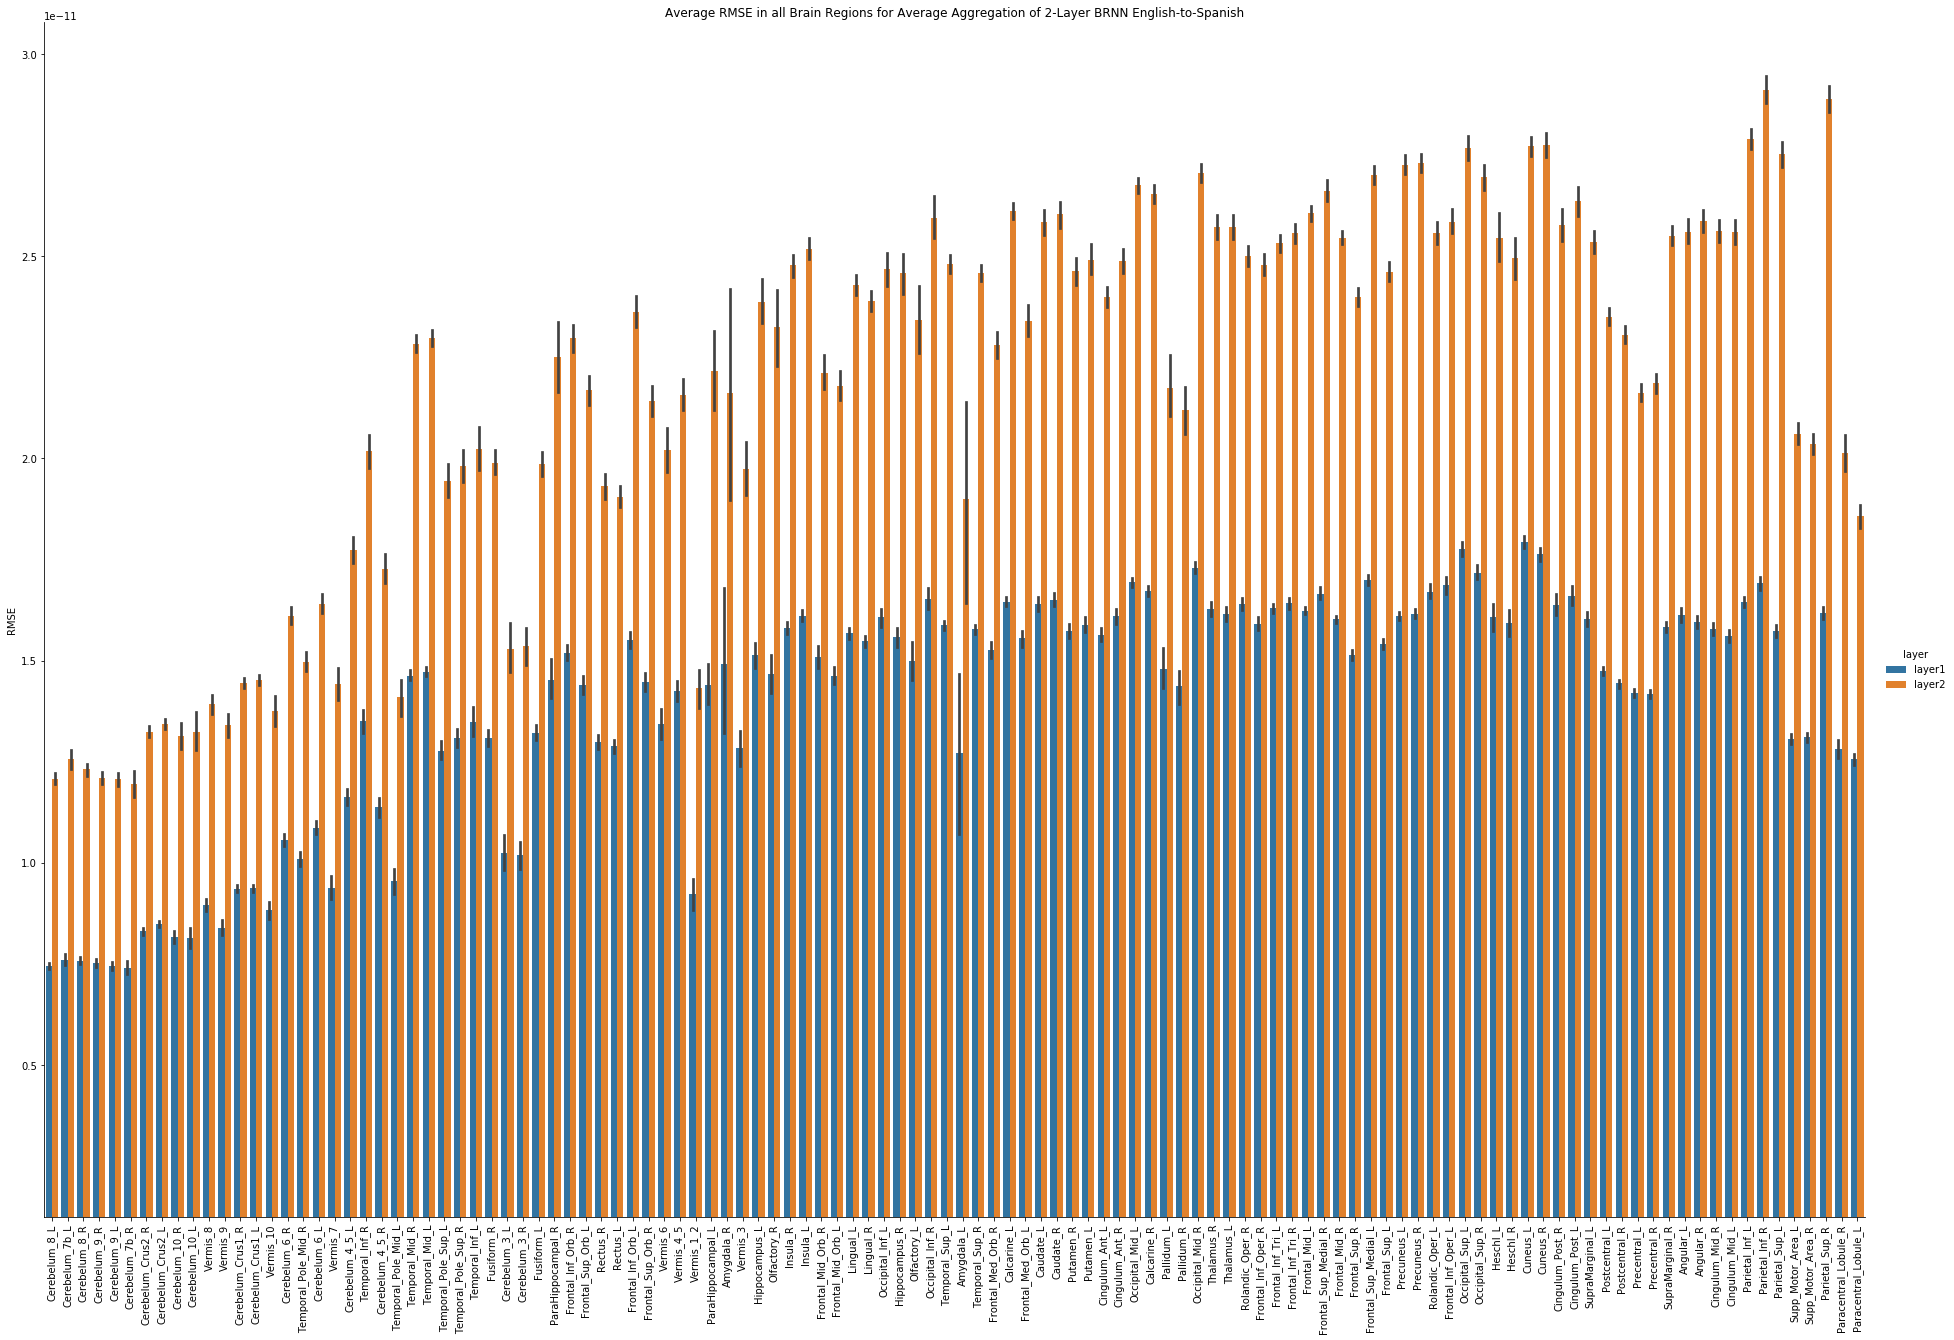

In [65]:
g = sns.catplot(x="atlas_labels", y="residuals", data=df_avg, hue="layer", kind="bar", height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Brain Regions for Average Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### max

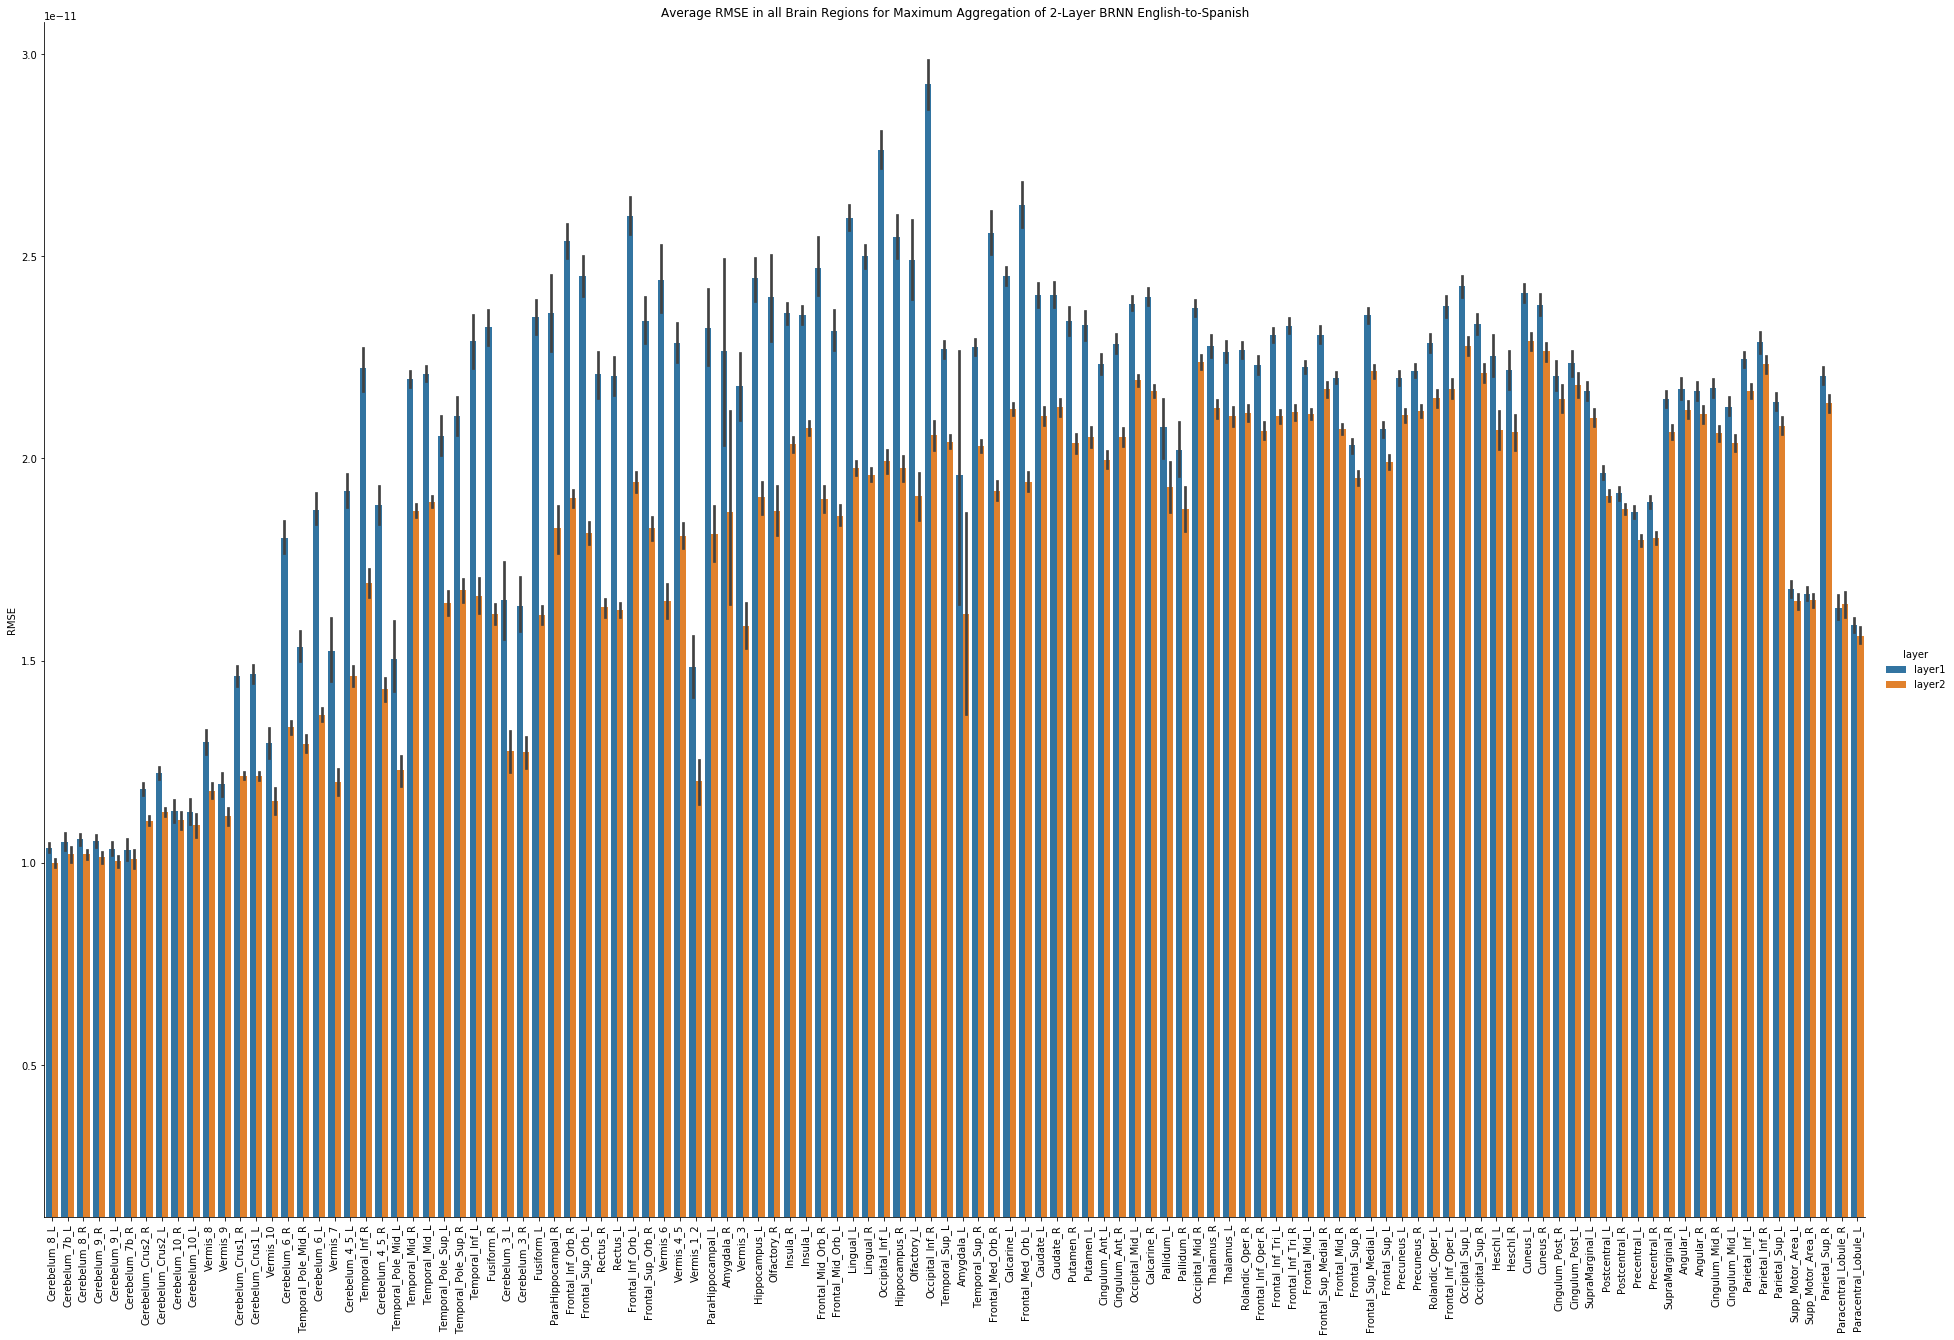

In [66]:
g = sns.catplot(x="atlas_labels", y="residuals", data=df_max, hue="layer", kind="bar", height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Brain Regions for Maximum Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### min

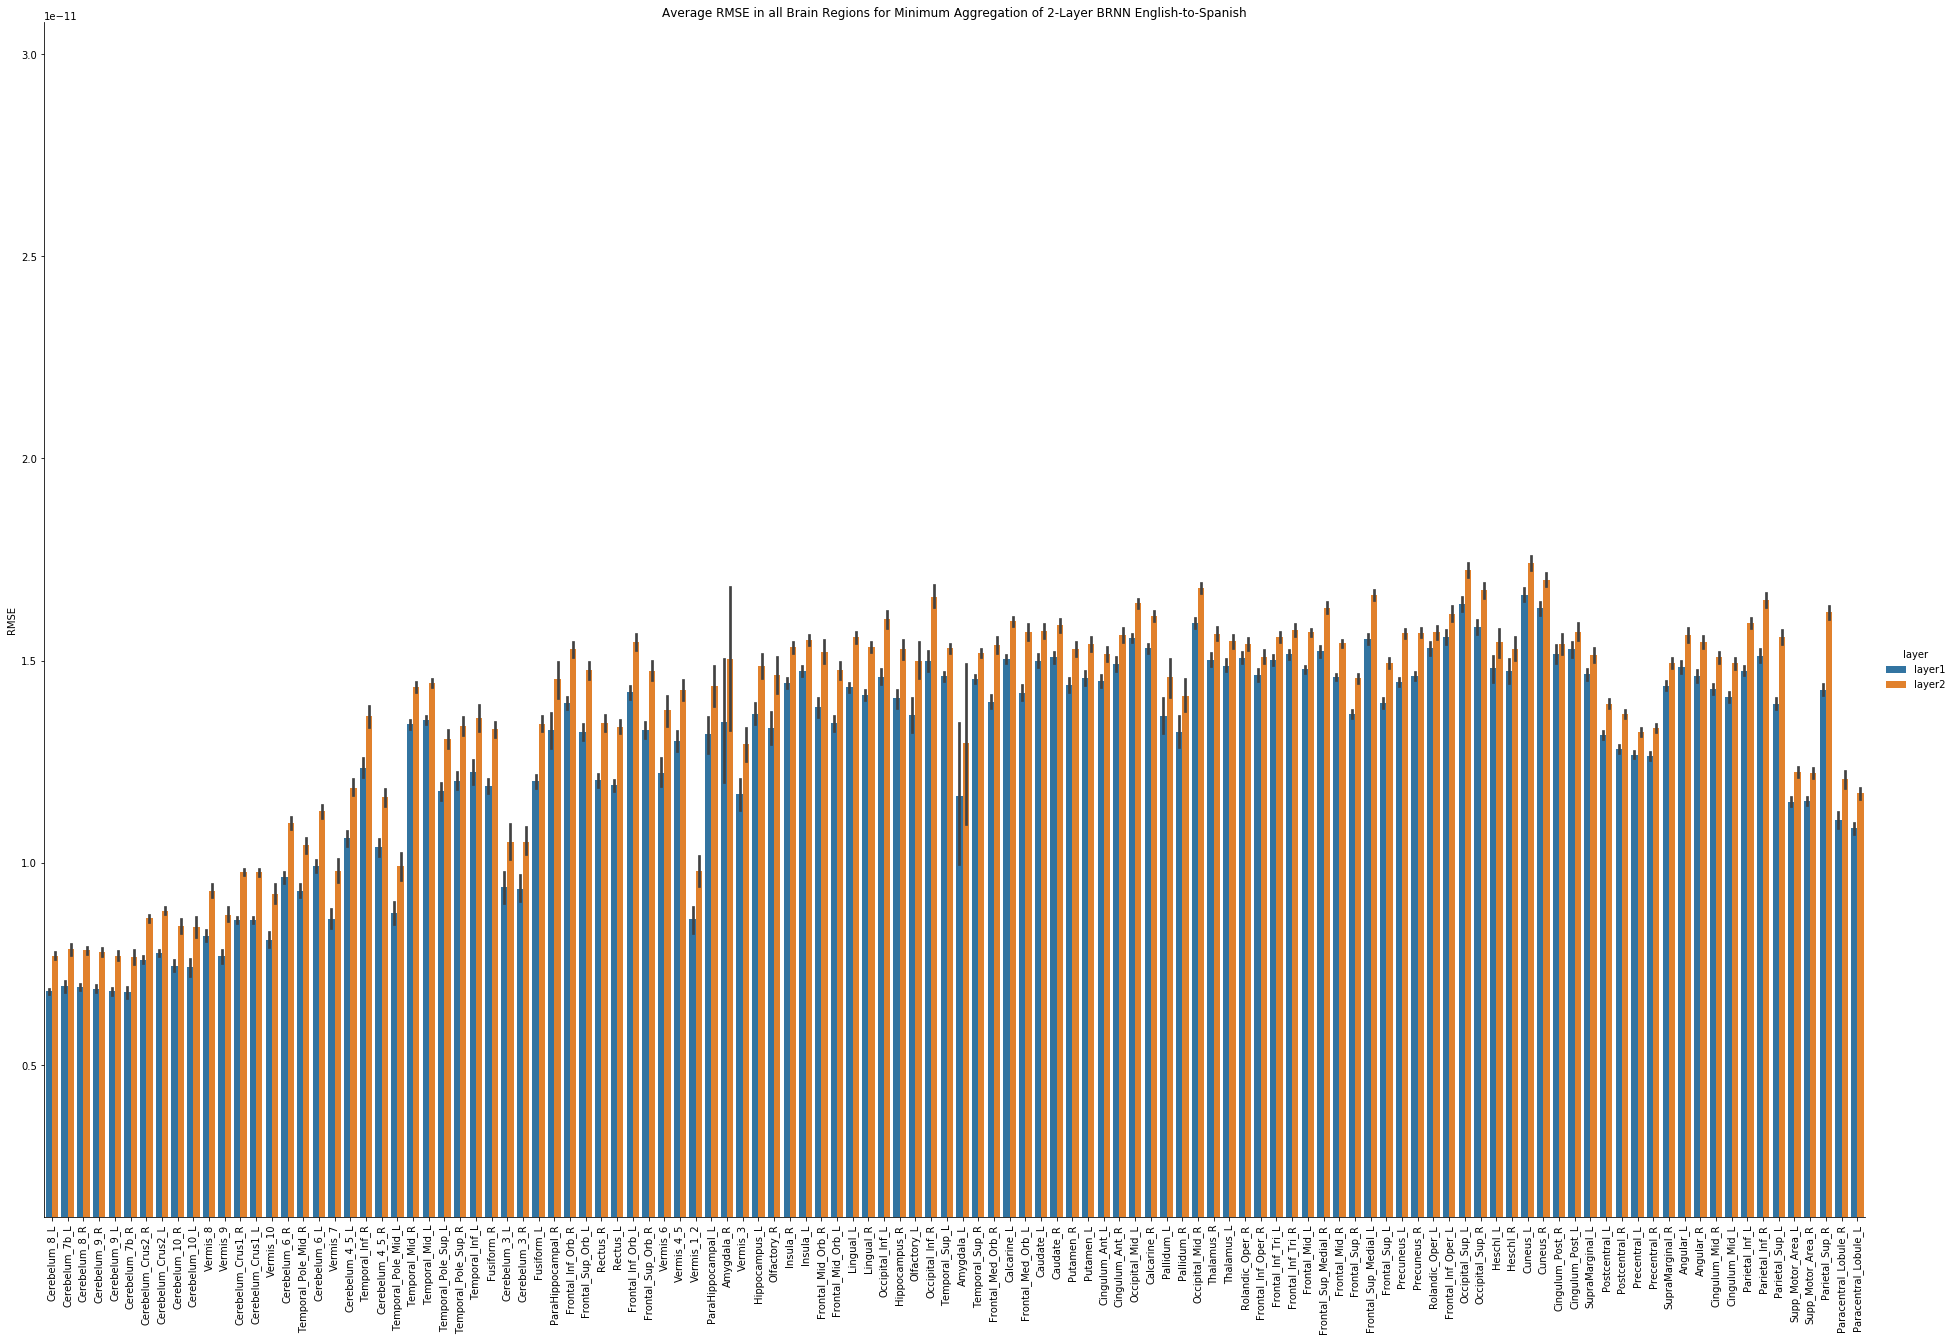

In [67]:
g = sns.catplot(x="atlas_labels", y="residuals", data=df_min, hue="layer", kind="bar", height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Brain Regions for Minimum Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### last

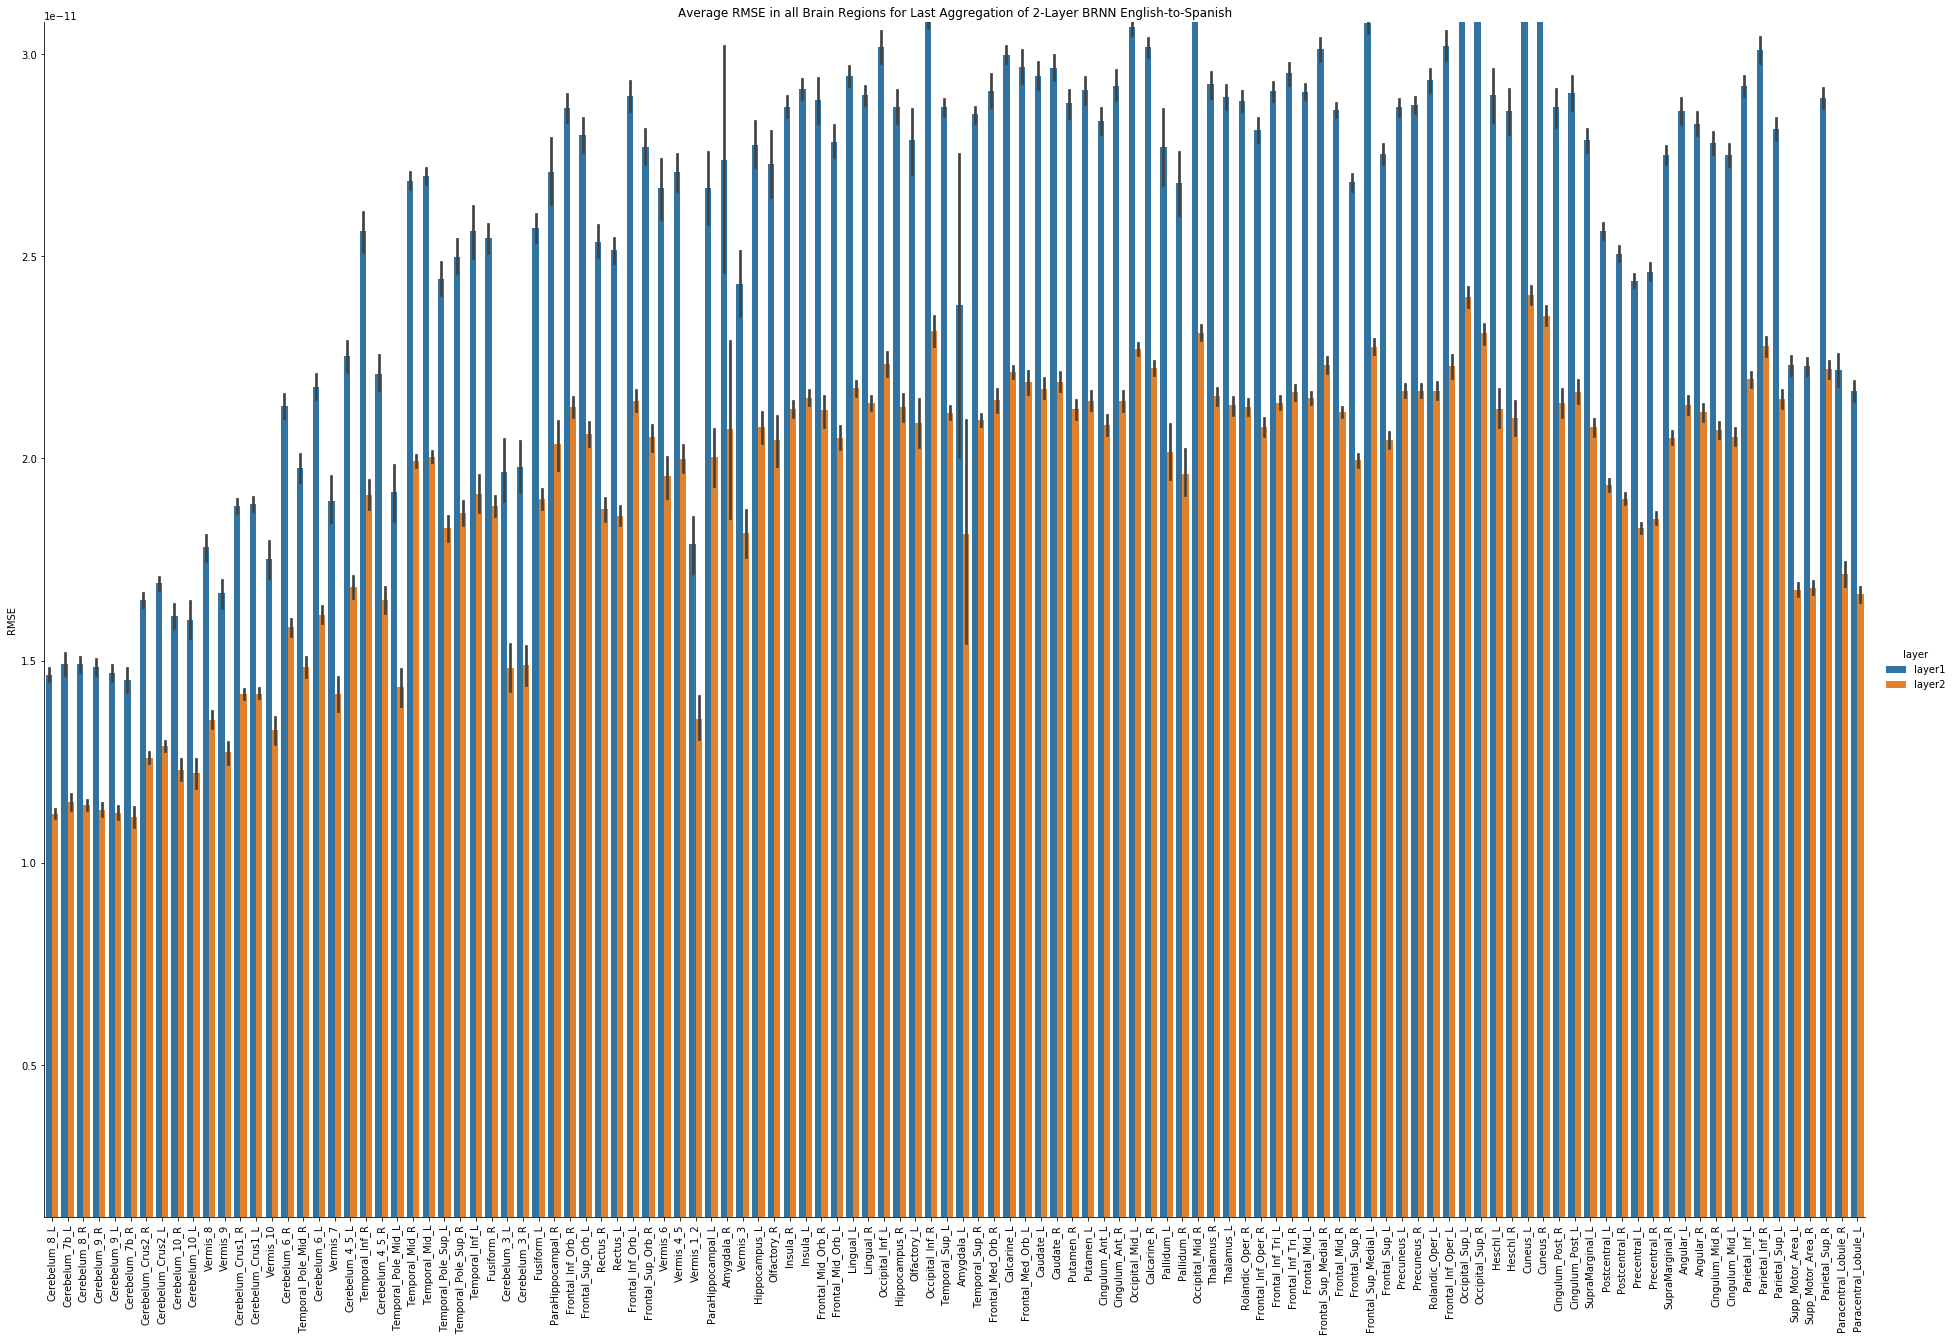

In [68]:
g = sns.catplot(x="atlas_labels", y="residuals", data=df_last, hue="layer", kind="bar", height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set_axis_labels("", "RMSE")
g.set(ylim=(min(df.residuals), max(df.residuals)/1.75))
plt.title("Average RMSE in all Brain Regions for Last Aggregation of 2-Layer BRNN English-to-Spanish")
plt.show()

### concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-avg trial

In [39]:
all_residuals = avg_residual_layer1

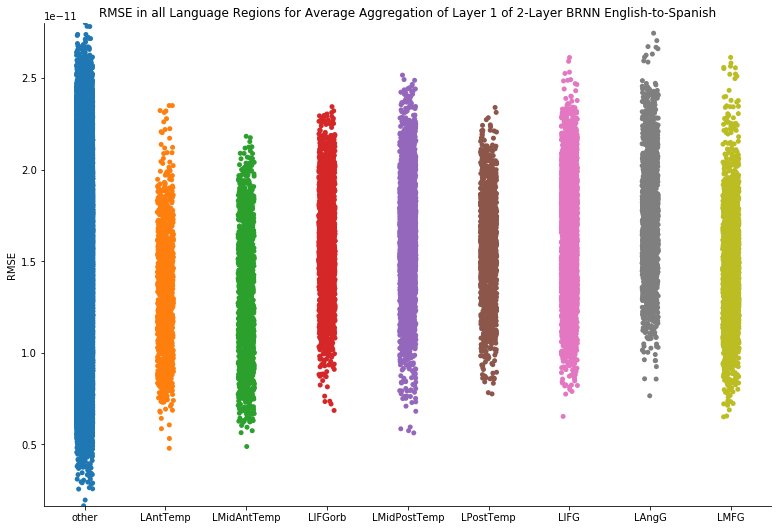

In [50]:
%matplotlib inline
g = sns.catplot(x="roi_labels", y="residuals", data=df_single, height=7.5, aspect=1.5)
# g.set_xticklabels(rotation=90)
g.set(ylim=(min(all_residuals), max(all_residuals)))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Language Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish")
# plt.savefig("roi.png")
plt.show()

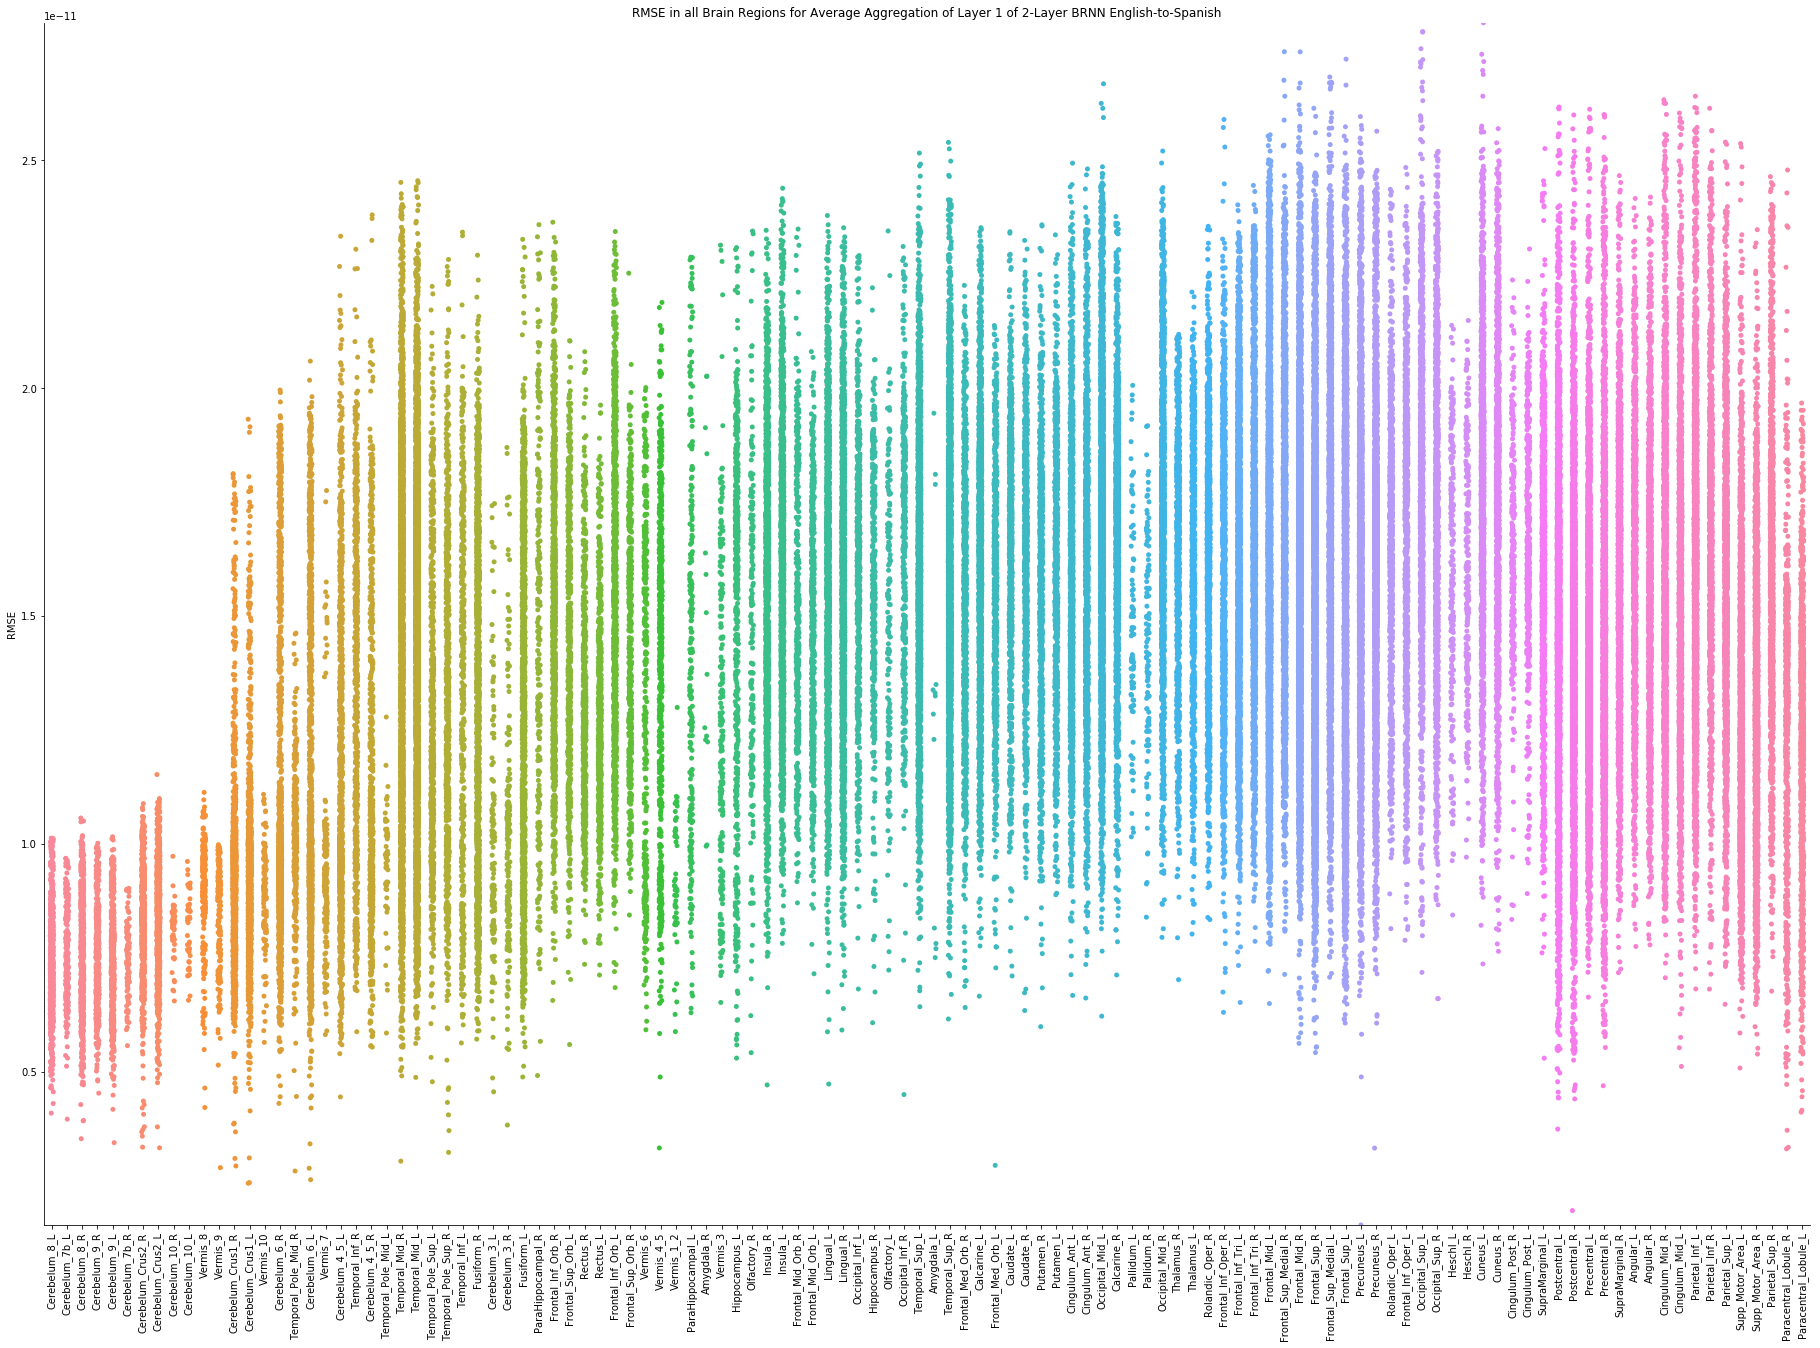

In [51]:
g = sns.catplot(x="atlas_labels", y="residuals", data=df_single, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(all_residuals), max(all_residuals)))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish")
# plt.savefig("atlas.png")
plt.show()

In [7]:
min(all_residuals)

1.6385860132508658e-12

In [8]:
max(all_residuals)

2.8020124515137374e-11